In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [13]:
pth = '/content/drive/MyDrive/MSIB/Tugas 4/dataset/'

image dimensions: (232, 232)


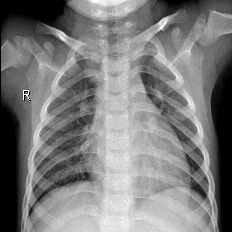

In [14]:
# Pillow for image processing
from PIL import Image

# Getting sample normal image
normal_image_path = pth+'TRAIN/NORMAL/NORMAL_101.png'
normal_image = Image.open(normal_image_path)
print("image dimensions:",normal_image.size)
normal_image

In [15]:
# Getting sample covid image
covid_image_path = pth+'TRAIN/COVID/COVID_207.png'
covid_image = Image.open(covid_image_path)
print("image dimensions:",covid_image.size)
covid_image

image dimensions: (256, 256)


In [16]:
# Getting train and test directories
train_dir = pth+"TRAIN"
test_dir = pth+"TEST"

In [17]:
from itertools import chain
from matplotlib import pyplot as plt

# Creating set of dimensions
unique_dimensions = set()
unique_modes = set()

# Iterating through all images
for subdir in chain(os.listdir(train_dir), os.listdir(test_dir)):
    subdir_path = os.path.join(train_dir, subdir)
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        image = Image.open(file_path)
        # Adding shape and mode of give image to sets
        unique_dimensions.add(image.size[0])
        unique_dimensions.add(image.size[1])
        unique_modes.add(image.mode)

print("unique modes:", unique_modes)
print("unique dimensions:", unique_dimensions)

unique modes: {'RGB'}
unique dimensions: {232, 256}


In [18]:
# Setting the dimensions for images to be resized to
DIMENSIONS = [232, 232]

#Modeling

In [19]:
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras import backend
import tensorflow as tf
import keras

# Creating simple model
def simple_model():
    # Clearning any model memory
    backend.clear_session()

    # Creating Sequential model
    model = Sequential()

    # Adding convolution layers
    model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform', activation="relu", input_shape=(*DIMENSIONS, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', activation="relu"))
    model.add(MaxPooling2D(2, 2))

    # Flattening the output and adding Dense layers
    model.add(Flatten())
    model.add(Dense(512, activation="relu", kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu", kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    return model

#Image Generator Pipeline

In [20]:
from keras.preprocessing.image import ImageDataGenerator

# Applying data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.25,
      height_shift_range=0.25,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      brightness_range=(0.8, 1.2),
      fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
# Flow from directory images using train_datagen and valid_datagen generators

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=tuple(DIMENSIONS),  # All images will be resized to 100x100
        class_mode='binary') # Since we use binary_crossentropy loss, we need binary labels

valid_generator = valid_datagen.flow_from_directory(
        test_dir,  # This is the source directory for training images
        target_size=tuple(DIMENSIONS),  # All images will be resized to 100x100
        class_mode='binary')

Found 563 images belonging to 2 classes.
Found 201 images belonging to 2 classes.


# Compiling And Training The Model

In [22]:
# Creating new model
model = simple_model()

# Parameters
BATCH_SIZE = 5
EPOCHS = 10

model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 230, 230, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 115, 115, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 128)       0

In [23]:
# Training the model
history = model.fit(
      train_generator,
      validation_data=valid_generator,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 60 else lr * tf.math.exp(-0.05))],
      verbose=1)

Epoch 1/10
18/18 [==============================] - 142s 8s/step - loss: 2.9924 - accuracy: 0.5684 - val_loss: 0.5996 - val_accuracy: 0.6617 - lr: 0.0010
Epoch 2/10
18/18 [==============================] - 99s 5s/step - loss: 0.5511 - accuracy: 0.7407 - val_loss: 0.4756 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 3/10
18/18 [==============================] - 100s 5s/step - loss: 0.5121 - accuracy: 0.7744 - val_loss: 0.4440 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 4/10
18/18 [==============================] - 107s 6s/step - loss: 0.4575 - accuracy: 0.7851 - val_loss: 0.3131 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 5/10
18/18 [==============================] - 105s 6s/step - loss: 0.4207 - accuracy: 0.8135 - val_loss: 0.4206 - val_accuracy: 0.8308 - lr: 0.0010
Epoch 6/10
18/18 [==============================] - 101s 6s/step - loss: 0.3875 - accuracy: 0.8242 - val_loss: 0.2747 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 7/10
18/18 [==============================] - 100s 6s/step - loss: 0.33

#Testing

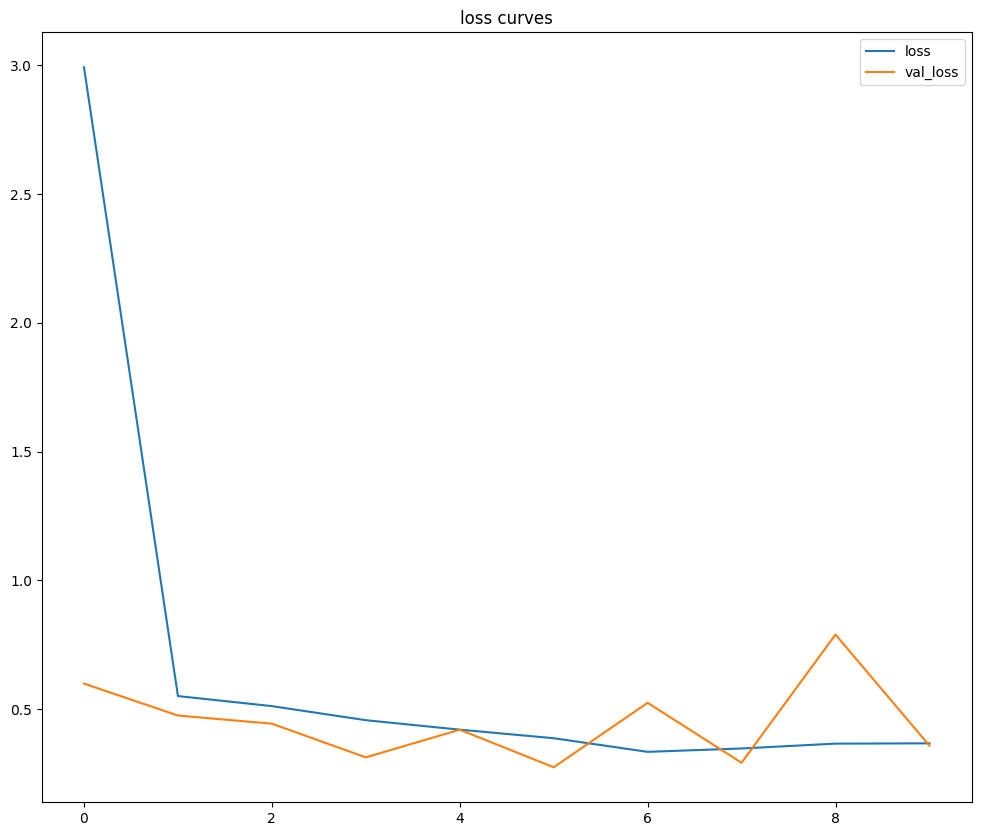

In [24]:
import matplotlib.pyplot as plt

# Plotting loss curves
plt.figure(figsize=(12,10))
plt.title("loss curves")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

In [25]:
# Plotting accuracy curves
plt.figure(figsize=(12,10))
plt.title("accuracy curves")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [26]:
# Creating new generator for test data
test_generator = valid_datagen.flow_from_directory(
        test_dir,  # This is the source directory for test images
        target_size=(DIMENSIONS),  # All images will be resized to 100x100
        class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
        shuffle=False)  # We don't want to shuffle the test data

# Predicting labels for all test images
y_pred = model.predict(test_generator)
y_pred[:10]

Found 201 images belonging to 2 classes.
7/7 [==============================] - 10s 1s/step


array([[0.00118327],
       [0.00668326],
       [0.01319608],
       [0.3154055 ],
       [0.04948788],
       [0.01429561],
       [0.05984926],
       [0.20326768],
       [0.04696366],
       [0.04593512]], dtype=float32)

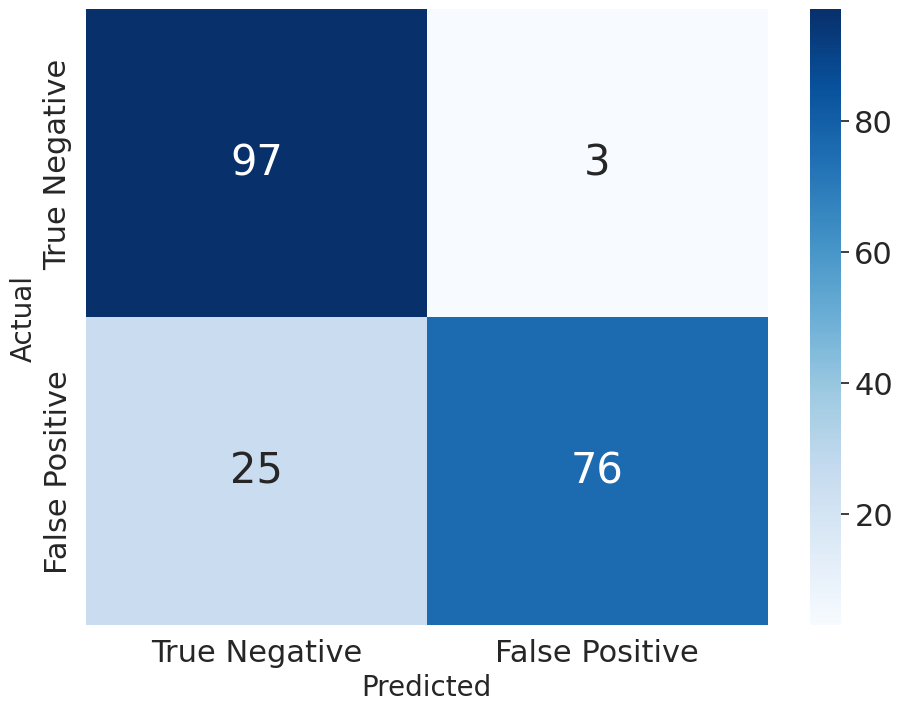

In [27]:
from sklearn.metrics import confusion_matrix

# Getting the true labels for the test data
y_true = test_generator.labels

# Converting the predicted labels to binary labels
y_pred = np.round(y_pred)

# Calculating the confusion matrix
confusion_matrix = confusion_matrix(y_true, y_pred)

# Displaying the confusion matrix
import seaborn as sns
from seaborn import heatmap

plt.figure(figsize=(11,8))
sns.set(font_scale=2)

heatmap(confusion_matrix,
        annot=True,
        annot_kws={"size": 30},
        fmt='g',
        cmap='Blues',
        xticklabels=['True Negative', 'False Positive'],
        yticklabels=['True Negative', 'False Positive'])

plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

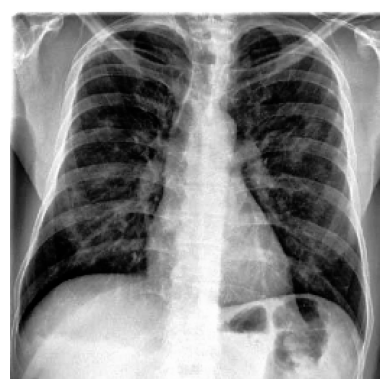

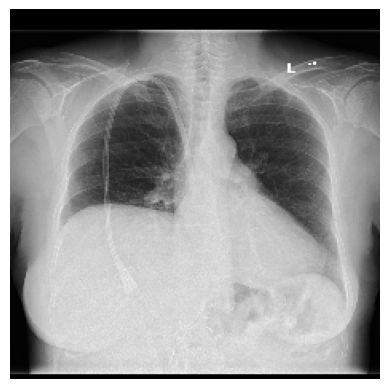

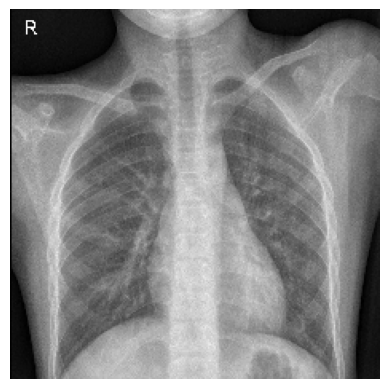

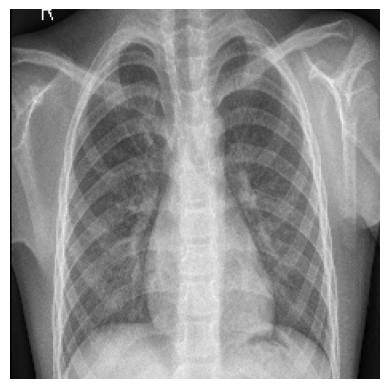

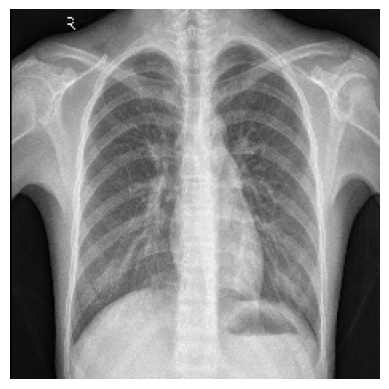

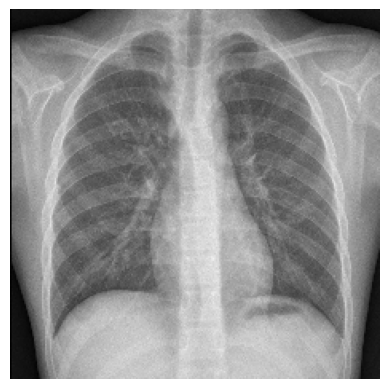

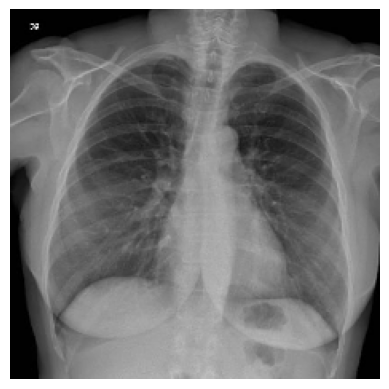

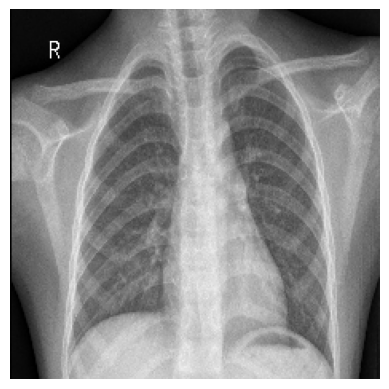

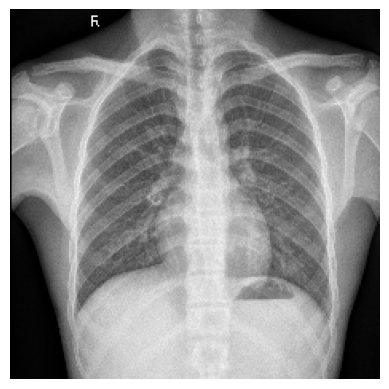

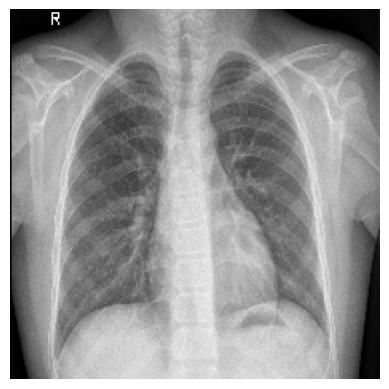

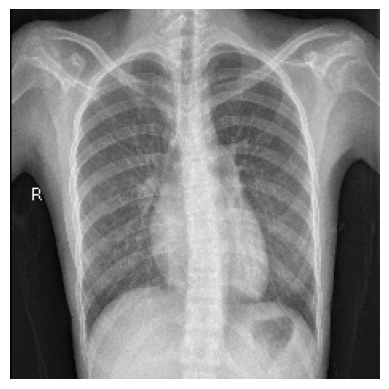

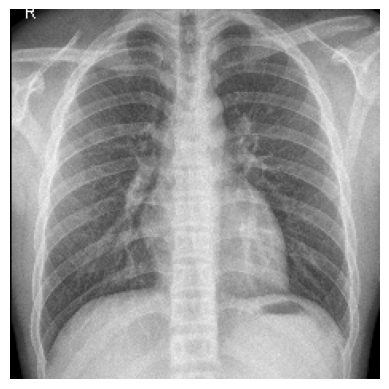

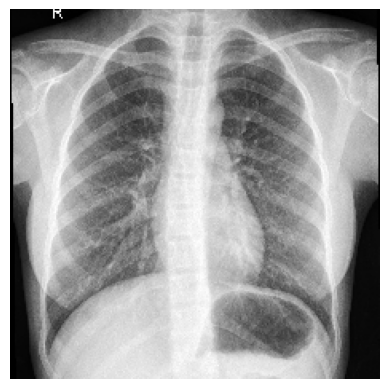

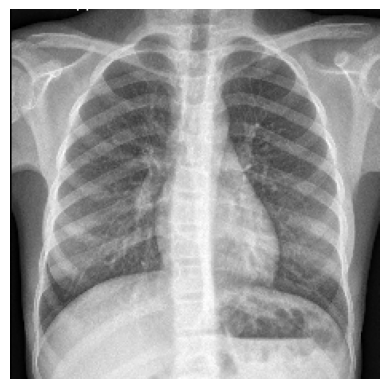

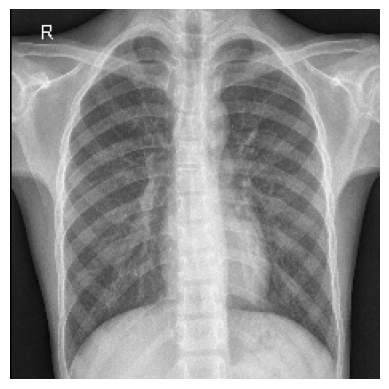

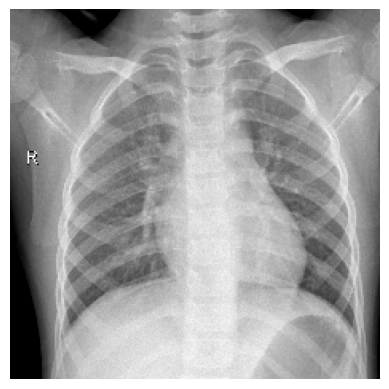

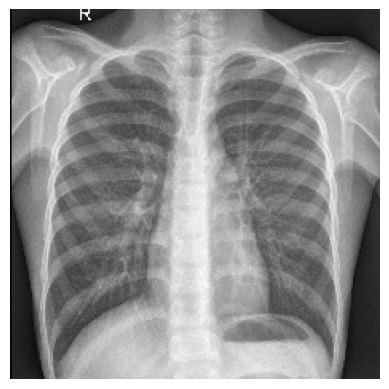

In [28]:
# Getting indecies of wrongly classified images
misclassified_indices = np.where(y_true.reshape(-1,1) != y_pred)[0]

# Displaying all wrongly classified images
for i in misclassified_indices:
    image_path = test_generator.filepaths[i]
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

1. Preprocessing : Saya menguragi dataset dari yang diberikan sekitar 3000+ data menjadi 300 saja karena perlengkapan yang tidak mendukung untuk memproses banyak data sekaligus. Kemudian saya membagi gambar yang akan menjadi train dan test. Karena ukuran gambar memiliki perbedaan, saya ambil ukuran terkecil yaitu 232 x 232, warna semua hanya RGB jadi sudah seragam.
2. Modeling : menggunakan model yang telah diberikan sebagai contoh sebelumnya, menggunakan dense = 1 dan sigmoid karena klasifikasi hanya berlaku secara biner. Pada awalnya saya stuck saat disini karena sebelumnya belum memisahkan data train dan test melalui folder.
3. Evaluasi : evaluasi menggunakan akurasi, dapat dilihat evaluasi cenderung naik, akan tetapi loss pada awalnya turun, namun pada grafik cenderung naik pada puncaknnya.